### Minimum Observations

In this simplest example, let's say you have a target consisting of a planetary system around a single cool, active dwarf. For this example, we'll use AU Mic. Let's say that, given an observing strategy of once per night, we want to know how many observations we would need to achieve a threshold uncertainty on the radial velocity semi-amplitude, K, of 10%. For AU Mic, with a K of 580 cm/s (Klein+ 2021), that means we want the minimum observations needed to reach an uncertainty of 58 cm/s. 

We'll start with the single planet case with a circular orbit and then generalize to include both AU Mic b and c. 

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
import tinygp
from tinygp import kernels
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils

1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

path = '/Users/chrislam/Desktop/gaspery/'

#### White noise case

We begin by declaring our target planet's orbital parameters. Our covariance matrix in the white noise regime is simply a diagonal matrix of the photon noise. In their modeling of AU Mic b, Klein+ 2021 estimated that noise to be 500 cm/s. 

In [62]:
### target parameters
p = 8.5 # orbital period, days
K = 580 # cm/s
T0 = 2360 # arbitrarily chosen fiducial central transit time, in BJD

### white/photon noise
sigma_wn_rv = 5 * 1e2 # [cm/s]

### choose arbitrary start time
start = 2352

We must also choose an observing cadence. The base case here is an observation once per day, for a cadence (time between observations) of 1 day.

In [63]:
c = 1 # observing cadence of once per day

Okay! The only thing we've left unconstrained is the number of observations. We can vary them, building an increasingly longer time series of observations, each time recalculating the covariance matrix, Fisher Information, and uncertainty on the RV semi-amplitude.

In [64]:
sigma_ks = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, cadence = 1, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()
        
    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat) # object-oriented with custom kernels
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks.append(sigma_k)
    

  0%|                                                                                                               | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_74713/379928564.py:37: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 636.66it/s]


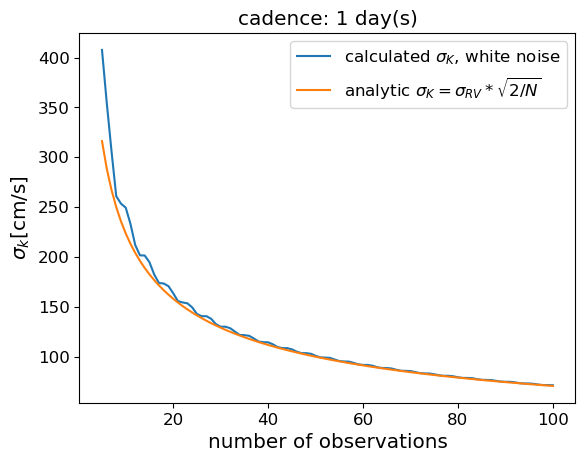

In [65]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks, label='calculated $\sigma_K$, white noise')
plt.plot(np.arange(len(sigma_ks))+5, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+5)), label='analytic $\sigma_K = \sigma_{RV}*\sqrt{2/N}$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s)")
plt.legend()
plt.show()

#### Correlated Noise Case

Finally, we declare the stellar noise parameters and populate the inputs for the covariance matrix and Fisher Information calculation functions.

In [66]:
### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # photon noise level [cm/s]

params = [sigma_wn_rv, Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

In [69]:
sigma_ks_qp = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                             Prot = Prot, sigma_qp_rv = sigma_qp_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, cadence = 1, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()
    
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar
    
    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
    sigma += 1e-6 

    #print(strat, sigma)
    #fadsfa
    
    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks_qp.append(sigma_k)
    

  0%|                                                                                                               | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_74713/2854766569.py:46: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 225.49it/s]


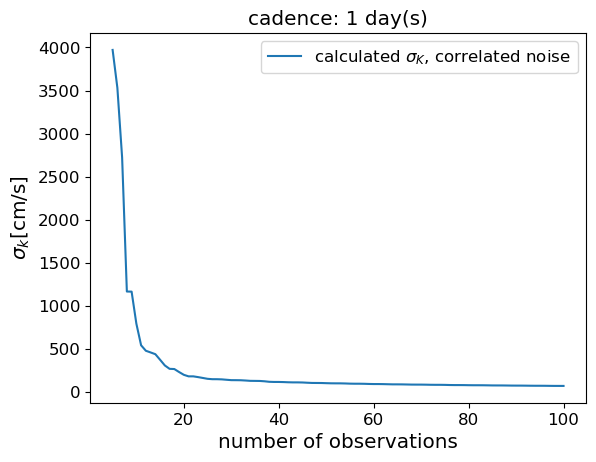

In [70]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s)")
plt.legend()
#plt.ylim([0,200])
plt.show()

#### A Brief Aside to Combine Plots for the Paper

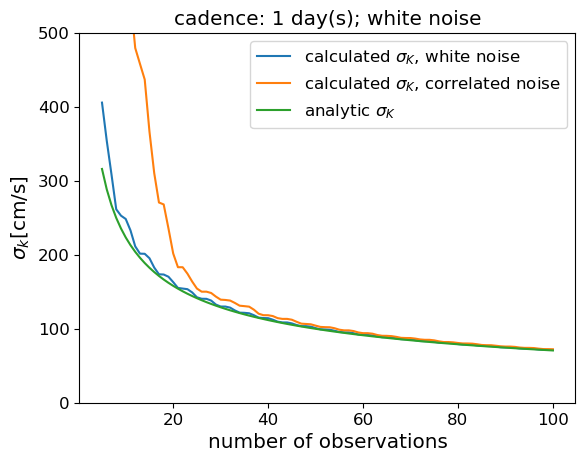

In [25]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks, label='calculated $\sigma_K$, white noise')
plt.plot(np.arange(len(sigma_ks_qp))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.plot(np.arange(len(sigma_ks))+5, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+5)), label='analytic $\sigma_K$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s); white noise")
plt.legend()
plt.ylim([0, 500])
plt.savefig(path + f"plots/au-mic/n_obs.png", format="png")
plt.show()

#### Custom kernel case

Let's say you want to make your own Gaussian Process kernel to model the stellar activity. Perhaps you want to investigate what observation strategies maximize the Fisher Information of some specific feature of the stellar activity.  

In [31]:
params = [sigma_wn_rv, Tau, eta, Prot, sigma_qp_rv]

In [72]:
class Quasiperiodic(tinygp.kernels.Kernel):
    
    def __init__(self, Tau, eta, Prot, sigma_qp_rv):
        self.sigma_wn_rv = sigma_wn_rv
        self.Tau = Tau
        self.eta = eta
        self.Prot = Prot
        self.sigma_qp_rv = sigma_qp_rv

    def evaluate(self, X1, X2):
        tdiff = jnp.abs(X1 - X2) 
        term1 = (tdiff**2) / (2*self.Tau**2)
        term2 = (1/(2*self.eta**2)) * (jnp.sin(jnp.pi * (tdiff)/self.Prot))**2
        arg = -term1 - term2
        k = jnp.exp(arg)
        K = self.sigma_qp_rv**2 * k
        return K
            

def build_gp(params, strat):

    kernel = Quasiperiodic(
        params[1], params[2], params[3], params[4] # omit the first param, which is for white noise and will be applied later
    )

    return kernel

# instantiate kernel object
kernel = build_gp(params, strat)

# call kernel on observation strategy time series to get covariance matrix with correlated noise terms only
k = kernel(strat, strat)

# add white noise to correlated noise kernel
k = k * sigma_wn_rv**2 * jnp.diag(np.ones(len(strat)))
k += 1e-6 
print(k)



[[5.5225e+12 1.0000e-06 1.0000e-06 ... 1.0000e-06 1.0000e-06 1.0000e-06]
 [1.0000e-06 5.5225e+12 1.0000e-06 ... 1.0000e-06 1.0000e-06 1.0000e-06]
 [1.0000e-06 1.0000e-06 5.5225e+12 ... 1.0000e-06 1.0000e-06 1.0000e-06]
 ...
 [1.0000e-06 1.0000e-06 1.0000e-06 ... 5.5225e+12 1.0000e-06 1.0000e-06]
 [1.0000e-06 1.0000e-06 1.0000e-06 ... 1.0000e-06 5.5225e+12 1.0000e-06]
 [1.0000e-06 1.0000e-06 1.0000e-06 ... 1.0000e-06 1.0000e-06 5.5225e+12]]


Let's call the custom kernel in the framework we used with the out-of-the-box kernels from tinygp.

In [74]:
sigma_ks_qp = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                             Prot = Prot, sigma_qp_rv = sigma_qp_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, cadence = 1, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()
    
    # build covariance matrix, characterized by a custom quasi-periodic noise model of the stellar signal
    kernel = build_gp(params, strat)
    
    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks_qp.append(sigma_k)
    

  0%|                                                                                                               | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_74713/73394888.py:42: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 244.44it/s]


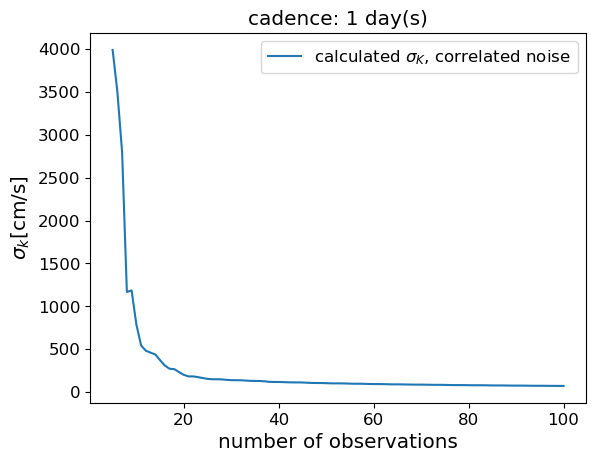

In [75]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s)")
plt.legend()
#plt.ylim([0,200])
plt.show()

Huzzah, the custom quasi-periodic Gaussian Process kernel matches the result from the out-of-the-box quasi-periodic GP kernel!

#### Visualize what a good strategy is sampling in phase space

The plot above is all well and good for confirming our hunch that more observations means better K estimates, but it doesn't really give us great intuition on **why** more observations is good. To get at this, let's phase fold the signal and plot the best strategy (ie. N = 99 observations) over it, to see the phase coverage. At the most basic level, the better the phase coverage, the better we have a handle on the RV semi-major amplitude.

We phase fold on the orbital period of the planet. First, let's phase fold the time support. Here, we'll show 200 days out from our arbitrary start date.

In [76]:
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24) # support
t_phase_folded = t % p # phase fold support

Now, let's phase fold the planet signal.

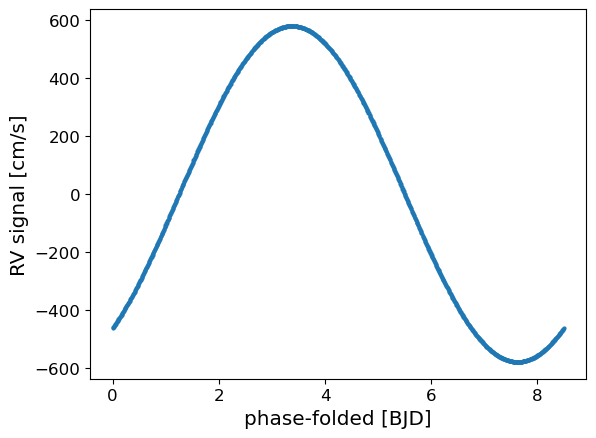

In [77]:
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, K, p, T0))

plt.scatter(t % p, y_phase_folded, s=4)
plt.ylabel('RV signal [cm/s]')
plt.xlabel('phase-folded [BJD]')
plt.show()

Then, let's phase fold the stellar signal and add it to the planet signal to get out the observed signal. We will use celerite2 (https://celerite2.readthedocs.io/en/latest/) to create a quasi-periodic Gaussian Process kernel and draw one (1) sample that we phase-fold, in order to illustrate the observational sampling over a realistic signal. 

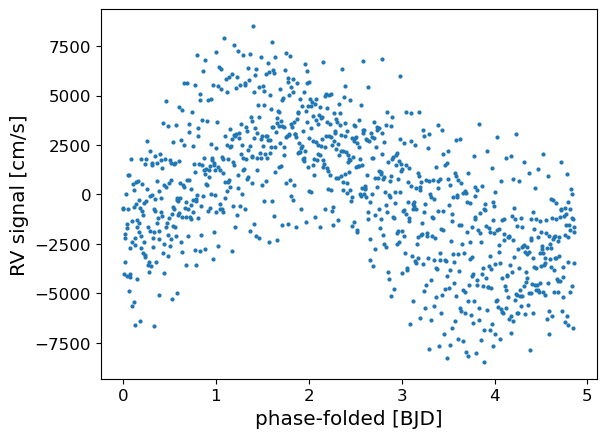

In [78]:
import celerite2
from celerite2 import terms

# quasiperiodic term
kernel = terms.SHOTerm(sigma=sigma_qp_rv, rho=Prot, tau=Tau)

# set up GP
gp = celerite2.GaussianProcess(kernel, mean=0.)

# compute GP
gp.compute(t, yerr=sigma_wn_rv)

# just take one sample to phase-fold for visualization purposes
sample = gp.sample(size=1)

# plot
plt.scatter(t % Prot, sample, s=4)
plt.ylabel('RV signal [cm/s]')
plt.xlabel('phase-folded [BJD]')
plt.show()

But hold on! Notice the vague suggestion of structure in the plot above. This structure shakes out because we phase fold by the rotation period, on which the correlated noise model depends -- however, we want the **planet** signal. 

When we phase fold on the orbital period, we get a lot less information.

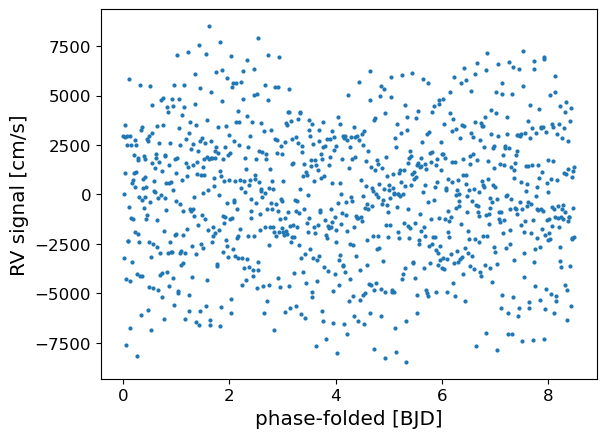

In [79]:
# plot
plt.scatter(t % p, sample, s=4)
plt.ylabel('RV signal [cm/s]')
plt.xlabel('phase-folded [BJD]')
plt.show()

Let's plot the phase folded planet plus stellar signal along with a dotted red line for every observation timestamp in the best (N = 99 observations) strategy. 

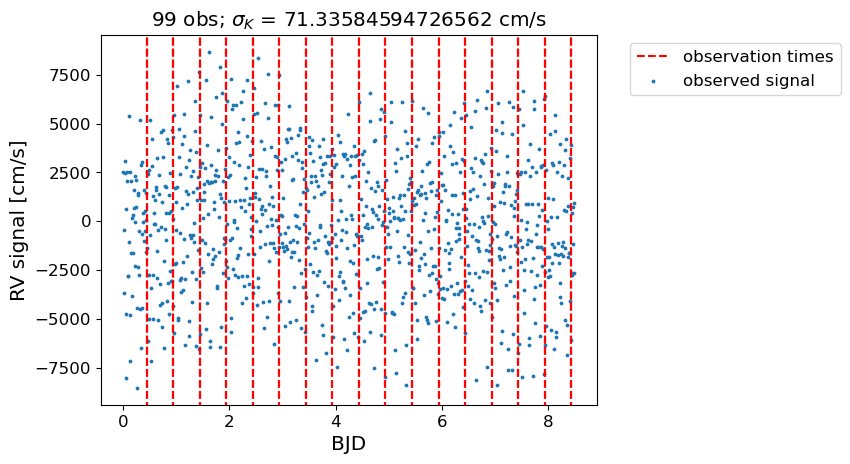

In [80]:
sigma_k_qp = min(sigma_ks)

plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % p, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r', alpha=0.5)
    
plt.scatter(t % p, sample + y_phase_folded, label='observed signal', s=3)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV signal [cm/s]')
plt.title(f'{n_obs} obs; ' + r'${\sigma}_K$' + f' = {sigma_k_qp} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

That doesn't look very informative, so let's bin down the RV data, as done by Plavchan+2020.

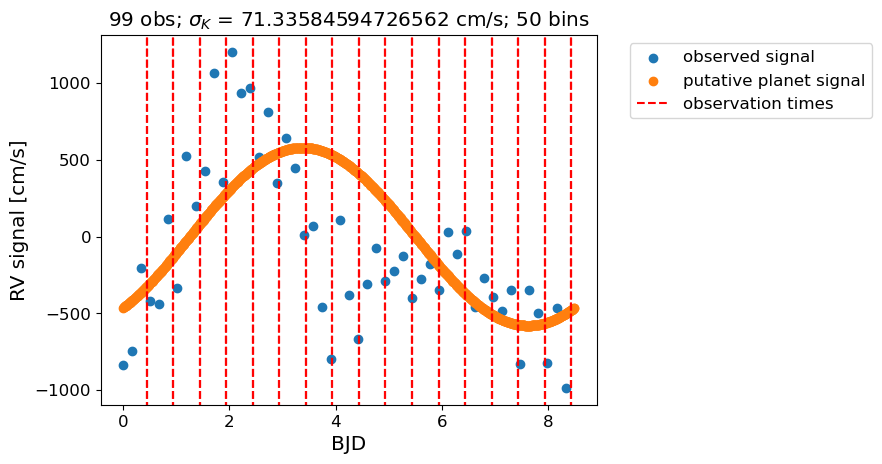

In [86]:
from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(t, theta[0], theta[1], theta[2])

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 50
mean_stat = binned_statistic(t % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

#print(mean_stat.statistic)
#print(mean_stat.bin_edges)
#print(mean_stat.binnumber)

plt.scatter(mean_stat.bin_edges[:-1], mean_stat.statistic, label='observed signal')
plt.scatter(t % p, y_phase_folded, label='putative planet signal')

plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % p, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r', alpha=0.5)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV signal [cm/s]')
plt.title(f'{n_obs} obs; ' + r'${\sigma}_K$' + f' = {sigma_k_qp} cm/s; ' + f'{bins} bins')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Multi-planet case

#### DFM

In [ ]:
kernel(strat, strat)